# Bioinformatics project (pNeRF)

## pNeRF algorithm
### Importing libraries and defining constants

In [1]:
"""
pNeRF algorithm for parallelized conversion from torsion (dihedral) angles to
Cartesian coordinates implemented with PyTorch.
Reference implementation in tensorflow by Mohammed AlQuraishi:
    https://github.com/aqlaboratory/pnerf/blob/master/pnerf.py
Paper (preprint) by Mohammed AlQuraishi:
    https://www.biorxiv.org/content/early/2018/08/06/385450
PyTorch implementation by Felix Opolka
"""

import math
import collections
import numpy as np
import torch
import torch.nn.functional as F
import torch.distributions.constraints as constraints

import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
%matplotlib inline

# Constants
NUM_DIMENSIONS = 3
NUM_DIHEDRALS = 3
BOND_LENGTHS = np.array([145.801, 152.326, 132.868], dtype=np.float32)
BOND_ANGLES = np.array([2.124, 1.941, 2.028], dtype=np.float32)

### From dihedrals to SRF coordinates

In [2]:
def dihedral_to_point(dihedral, bond_lengths=BOND_LENGTHS,
                      bond_angles=BOND_ANGLES):
    """
    Takes triplets of dihedral angles (phi, psi, omega) and returns 3D points
    ready for use in reconstruction of coordinates. Bond lengths and angles
    are based on idealized averages.
    :param dihedral: [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
    :return: Tensor containing points of the protein's backbone atoms.
    Shape [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
    """
    num_steps = dihedral.shape[0]
    batch_size = dihedral.shape[1]

    r_cos_theta = torch.tensor(bond_lengths * np.cos(np.pi - bond_angles))
    r_sin_theta = torch.tensor(bond_lengths * np.sin(np.pi - bond_angles))

    point_x = r_cos_theta.view(1, 1, -1).repeat(num_steps, batch_size, 1)
    point_y = torch.cos(dihedral) * r_sin_theta
    point_z = torch.sin(dihedral) * r_sin_theta

    point = torch.stack([point_x, point_y, point_z])
    point_perm = point.permute(1, 3, 2, 0)
    point_final = point_perm.contiguous().view(num_steps*NUM_DIHEDRALS,
                                               batch_size,
                                               NUM_DIMENSIONS)
    return point_final

### From SRF coordinates to actual coordinates

In [3]:
def point_to_coordinate(points, num_fragments=1):
    """
    Takes points from dihedral_to_point and sequentially converts them into
    coordinates of a 3D structure.
    Reconstruction is done in parallel by independently reconstructing
    num_fragments and the reconstituting the chain at the end in reverse order.
    The core reconstruction algorithm is NeRF, based on
    DOI: 10.1002/jcc.20237 by Parsons et al. 2005.
    The parallelized version is described in
    https://www.biorxiv.org/content/early/2018/08/06/385450.
    :param points: Tensor containing points as returned by `dihedral_to_point`.
    Shape [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
    :param num_fragments: Number of fragments in which the sequence is split
    to perform parallel computation.
    :return: Tensor containing correctly transformed atom coordinates.
    Shape [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
    """

    # Compute optimal number of fragments if needed
    total_num_angles = points.shape[0] # NUM_STEPS x NUM_DIHEDRALS
    if num_fragments is None:
        num_fragments = int(math.sqrt(total_num_angles))

    # Initial three coordinates (specifically chosen to eliminate need for
    # extraneous matmul)
    Triplet = collections.namedtuple('Triplet', 'a, b, c')
    batch_size = points.shape[1]
    init_matrix = np.array([[-np.sqrt(1.0 / 2.0), np.sqrt(3.0 / 2.0), 0],
                         [-np.sqrt(2.0), 0, 0], [0, 0, 0]],
                        dtype=np.float32)
    init_matrix = torch.from_numpy(init_matrix)
    init_coords = [row.repeat([num_fragments * batch_size, 1])
                      .view(num_fragments, batch_size, NUM_DIMENSIONS)
                   for row in init_matrix]
    init_coords = Triplet(*init_coords)                                     # NUM_DIHEDRALS x [NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS]

    # Pad points to yield equal-sized fragments
    padding = ((num_fragments - (total_num_angles % num_fragments))
               % num_fragments)                                             # (NUM_FRAGS x FRAG_SIZE) - (NUM_STEPS x NUM_DIHEDRALS)
    points = F.pad(points, (0, 0, 0, 0, 0, padding))                        # [NUM_FRAGS x FRAG_SIZE, BATCH_SIZE, NUM_DIMENSIONS]
    points = points.view(num_fragments, -1, batch_size, NUM_DIMENSIONS)     # [NUM_FRAGS, FRAG_SIZE, BATCH_SIZE, NUM_DIMENSIONS]
    points = points.permute(1, 0, 2, 3)                                     # [FRAG_SIZE, NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS]

    # Extension function used for single atom reconstruction and whole fragment
    # alignment
    def extend(prev_three_coords, point, multi_m):
        """
        Aligns an atom or an entire fragment depending on value of `multi_m`
        with the preceding three atoms.
        :param prev_three_coords: Named tuple storing the last three atom
        coordinates ("a", "b", "c") where "c" is the current end of the
        structure (i.e. closest to the atom/ fragment that will be added now).
        Shape NUM_DIHEDRALS x [NUM_FRAGS/0, BATCH_SIZE, NUM_DIMENSIONS].
        First rank depends on value of `multi_m`.
        :param point: Point describing the atom that is added to the structure.
        Shape [NUM_FRAGS/FRAG_SIZE, BATCH_SIZE, NUM_DIMENSIONS]
        First rank depends on value of `multi_m`.
        :param multi_m: If True, a single atom is added to the chain for
        multiple fragments in parallel. If False, an single fragment is added.
        Note the different parameter dimensions.
        :return: Coordinates of the atom/ fragment.
        """
        bc = F.normalize(prev_three_coords.c - prev_three_coords.b, dim=-1)
        n = F.normalize(torch.cross(prev_three_coords.b - prev_three_coords.a,
                                    bc), dim=-1)
        if multi_m:     # multiple fragments, one atom at a time
            m = torch.stack([bc, torch.cross(n, bc), n]).permute(1, 2, 3, 0)
        else:           # single fragment, reconstructed entirely at once.
            s = point.shape + (3,)
            m = torch.stack([bc, torch.cross(n, bc), n]).permute(1, 2, 0)
            m = m.repeat(s[0], 1, 1).view(s)
        coord = torch.squeeze(torch.matmul(m, point.unsqueeze(3)),
                              dim=3) + prev_three_coords.c
        return coord

    # Loop over FRAG_SIZE in NUM_FRAGS parallel fragments, sequentially
    # generating the coordinates for each fragment across all batches
    coords_list = [None] * points.shape[0]                                  # FRAG_SIZE x [NUM_FRAGS, BATCH_SIZE, NUM_DIMENSIONS]
    prev_three_coords = init_coords

    for i in range(points.shape[0]):    # Iterate over FRAG_SIZE
        coord = extend(prev_three_coords, points[i], True)
        coords_list[i] = coord
        prev_three_coords = Triplet(prev_three_coords.b,
                                    prev_three_coords.c,
                                    coord)

    coords_pretrans = torch.stack(coords_list).permute(1, 0, 2, 3)

    # Loop backwards over NUM_FRAGS to align the individual fragments. For each
    # next fragment, we transform the fragments we have already iterated over
    # (coords_trans) to be aligned with the next fragment
    coords_trans = coords_pretrans[-1]
    for i in reversed(range(coords_pretrans.shape[0]-1)):
        # Transform the fragments that we have already iterated over to be
        # aligned with the next fragment `coords_trans`
        transformed_coords = extend(Triplet(*[di[i]
                                              for di in prev_three_coords]),
                                    coords_trans, False)
        coords_trans = torch.cat([coords_pretrans[i], transformed_coords], 0)

    coords = F.pad(coords_trans[:total_num_angles-1], (0, 0, 0, 0, 1, 0))

    return coords/100

## Creating random peptides

### Setting parameters

In [4]:
# Setting a random seed
pyro.set_rng_seed(101)

# Setting the mu and kappa parameters for creating a fake dataset
mu_psi_1_dist    = torch.distributions.Normal(1, 0.01)
kappa_psi_1_dist = torch.distributions.Normal(300, 1)

mu_phi_2_dist    = torch.distributions.Normal(2, 0.01)
kappa_phi_2_dist = torch.distributions.Normal(600, 2)

mu_psi_2_dist    = torch.distributions.Normal(0.5, 0.01)
kappa_psi_2_dist = torch.distributions.Normal(600, 2)

mu_phi_3_dist    = torch.distributions.Normal(0, 0.01)
kappa_phi_3_dist = torch.distributions.Normal(900, 3)

### Sampling from Von Mises

In [5]:
def Sampler_VM(n_samples, n_AA, mus, kappas, used_angles=[True, True, True]):
    phi = used_angles[0]
    psi = used_angles[1]
    omega = used_angles[2]
    
    # Making samples    
    samples = []
    for AA in range(n_AA):
        angles = []
        for sample in range(n_samples):
            dihedral_angles = []
            if phi and AA != 0:
                phi_angle = pyro.distributions.VonMises(mus[AA][0].sample_n(1).item(),
                                                              kappas[AA][0].sample_n(1).item()).sample_n(1).item()
                dihedral_angles.append(float(phi_angle))
            else:
                dihedral_angles.append(float(0.))
                
            if psi and AA != n_AA-1:
                psi_angle = pyro.distributions.VonMises(mus[AA][1].sample_n(1).item(),
                                                              kappas[AA][1].sample_n(1).item()).sample_n(1).item()
                dihedral_angles.append(float(psi_angle))
            else:
                dihedral_angles.append(float(0.))
                
            if omega and AA != n_AA-1:
                omega_angle = np.pi
                dihedral_angles.append(float(omega_angle))
            else:
                dihedral_angles.append(float(0.))
            
            angles.append(np.array((dihedral_angles)))
                
        samples.append(angles)

    samples = torch.tensor(samples)
    return samples

In [6]:
mus = [[None, mu_psi_1_dist, None], [mu_phi_2_dist, mu_psi_2_dist, None], [mu_phi_3_dist, None, None]]
kappas = [[None, kappa_psi_1_dist, None], [kappa_phi_2_dist, kappa_psi_2_dist, None], [kappa_phi_3_dist, None, None]]
_3DA_atoms = Sampler_VM(1000, 3, mus, kappas, used_angles=[True, True, True])

print(_3DA_atoms.shape)
print(_3DA_atoms[0][1])

C:\Users\antan\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\distributions\distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


torch.Size([3, 1000, 3])
tensor([0.0000, 1.0034, 3.1416], dtype=torch.float64)


### Visualising the Von Mises distribution

In [7]:
def plotting_VM(data_1, AAs, angles, data_2=torch.tensor([[[0.]]])):
    n_samples = len(data_1[0])
    
    # the histogram of the data
    plt.figure()
    if data_2.shape[1] == 1:
        for AA in range(len(AAs)):
            color = plt.rcParams['axes.prop_cycle'].by_key()['color']
            if angles[AA] == 0:
                da = 'phi'
            elif angles[AA] == 1:
                da = 'psi'
            else:
                da = 'omega'
            n, bins, patches = plt.hist([sample[angles[AA]] for sample in data_1[AAs[AA]-1][:]], 40, density=1, alpha=0.5)
    else:
        for AA in range(len(AAs)):
            color = plt.rcParams['axes.prop_cycle'].by_key()['color']
            if angles[AA] == 0:
                da = 'phi'
            elif angles[AA] == 1:
                da = 'psi'
            else:
                da = 'omega'
            n, bins, patches = plt.hist([sample[angles[AA]] for sample in data_1[AAs[AA]-1][:]], 40, density=1, alpha=0.5)
            n, bins, patches = plt.hist([sample[angles[AA]] for sample in data_2[AAs[AA]-1][:]], 40, density=1, alpha=0.5)
    plt.xlabel('Angle')
    plt.ylabel('Probability')
    plt.title('Histogram of dihedral angles (# of samples - {})'.format(n_samples))  
    plt.grid(True)
    plt.savefig('Output\\fake_data_angles')
    plt.show()

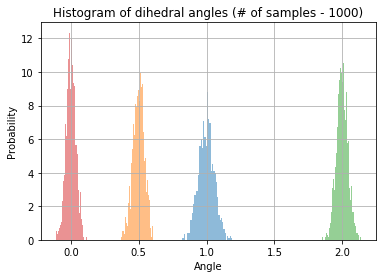

In [8]:
plotting_VM(_3DA_atoms, [1,2,2,3], [1,1,0,0])

## Pyro model for dihedral angles

### Model and guide (plate, vectorised)

In [9]:
pyro.set_rng_seed(101)

# clear the param store in case we're in REPL
pyro.clear_param_store()

def model_3DA(data):
    # Sampling mu and kappa
    mu_psi_1        = pyro.sample("mu_psi_1", dist.Uniform(-np.pi, np.pi))
    inv_kappa_psi_1 = pyro.sample("inv_kappa_psi_1", dist.HalfNormal(1.))
    kappa_psi_1     = 100 + 1/inv_kappa_psi_1
    
    mu_phi_2        = pyro.sample("mu_phi_2", dist.Uniform(-np.pi, np.pi))
    inv_kappa_phi_2 = pyro.sample("inv_kappa_phi_2", dist.HalfNormal(1.))
    kappa_phi_2     = 100 + 1/inv_kappa_phi_2
    
    mu_psi_2        = pyro.sample("mu_psi_2", dist.Uniform(-np.pi, np.pi))
    inv_kappa_psi_2 = pyro.sample("inv_kappa_psi_2", dist.HalfNormal(1.))
    kappa_psi_2     = 100 + 1/inv_kappa_psi_2
    
    mu_phi_3        = pyro.sample("mu_phi_3", dist.Uniform(-np.pi, np.pi))
    inv_kappa_phi_3 = pyro.sample("inv_kappa_phi_3", dist.HalfNormal(1.))
    kappa_phi_3     = 100 + 1/inv_kappa_phi_3
    
    # Looping over the observed data in an conditionally independant manner
    with pyro.plate('dihedral_angles'):
        pyro.sample("obs_psi_1", dist.VonMises(mu_psi_1, kappa_psi_1), obs=data[0,:,1])           
        pyro.sample("obs_phi_2", dist.VonMises(mu_phi_2, kappa_phi_2), obs=data[1,:,0])
        pyro.sample("obs_psi_2", dist.VonMises(mu_psi_2, kappa_psi_2), obs=data[1,:,1])            
        pyro.sample("obs_phi_3", dist.VonMises(mu_phi_3, kappa_phi_3), obs=data[2,:,0])
    
def guide_3DA(data):    
    # Hyperparameters    
    a_psi_1 = pyro.param('a_psi_1', torch.tensor(-np.pi), constraint=constraints.greater_than(-3.15)) 
    b_psi_1 = pyro.param('b_psi_1', torch.tensor(np.pi), constraint=constraints.less_than(3.15))
    x_psi_1 = pyro.param('x_psi_1', torch.tensor(2.), constraint=constraints.positive)
    
    a_phi_2 = pyro.param('a_phi_2', torch.tensor(-np.pi), constraint=constraints.greater_than(-3.15)) 
    b_phi_2 = pyro.param('b_phi_2', torch.tensor(np.pi), constraint=constraints.less_than(3.15))
    x_phi_2 = pyro.param('x_phi_2', torch.tensor(2.), constraint=constraints.positive)
    
    a_psi_2 = pyro.param('a_psi_2', torch.tensor(-np.pi), constraint=constraints.greater_than(-3.15)) 
    b_psi_2 = pyro.param('b_psi_2', torch.tensor(np.pi), constraint=constraints.less_than(3.15))
    x_psi_2 = pyro.param('x_psi_2', torch.tensor(2.), constraint=constraints.positive)
    
    a_phi_3 = pyro.param('a_phi_3', torch.tensor(-np.pi), constraint=constraints.greater_than(-3.15)) 
    b_phi_3 = pyro.param('b_phi_3', torch.tensor(np.pi), constraint=constraints.less_than(3.15))
    x_phi_3 = pyro.param('x_phi_3', torch.tensor(2.), constraint=constraints.positive)
    
    # Sampling mu and kappa
    pyro.sample("mu_psi_1", dist.Uniform(a_psi_1, b_psi_1))
    pyro.sample("inv_kappa_psi_1", dist.HalfNormal(x_psi_1))    
    pyro.sample("mu_phi_2", dist.Uniform(a_phi_2, b_phi_2))
    pyro.sample("inv_kappa_phi_2", dist.HalfNormal(x_phi_2))
    pyro.sample("mu_psi_2", dist.Uniform(a_psi_2, b_psi_2))
    pyro.sample("inv_kappa_psi_2", dist.HalfNormal(x_psi_2))    
    pyro.sample("mu_phi_3", dist.Uniform(a_phi_3, b_phi_3))
    pyro.sample("inv_kappa_phi_3", dist.HalfNormal(x_phi_3))
    


### Optimization using Adam

In [10]:
pyro.set_rng_seed(101)

# number of steps
n_steps = 2000

# setup the optimizer
adam_params_3DA_1st = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer_3DA_1st = Adam(adam_params_3DA_1st)

adam_params_3DA_2nd = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer_3DA_2nd = Adam(adam_params_3DA_2nd)

# setup the inference algorithm
svi_3DA_1st = SVI(model_3DA, guide_3DA, optimizer_3DA_1st, loss=Trace_ELBO())
svi_3DA_2nd = SVI(model_3DA, guide_3DA, optimizer_3DA_2nd, loss=Trace_ELBO())

losses_3DA, a_psi_2, b_psi_2, x_psi_2 = [], [], [], []
# do gradient steps
for step in range(n_steps):
    losses_3DA.append(svi_3DA_1st.step(_3DA_atoms.float()))
    a_psi_2.append(pyro.param('a_psi_2').item())
    b_psi_2.append(pyro.param('b_psi_2').item())
    x_psi_2.append(pyro.param('x_psi_2').item())
    if step % 200 == 0:
        print('1st iter {} steps:'.format(step), end='')
        print("psi_2_start: ", pyro.param("a_psi_2").item(), end='')
        print("\tpsi_2_end: ", pyro.param("b_psi_2").item(), end='')
        print("\tpsi_2_scale: ", pyro.param("x_psi_2").item())
        
for step in range(n_steps):
    losses_3DA.append(svi_3DA_2nd.step(_3DA_atoms.float()))
    a_psi_2.append(pyro.param('a_psi_2').item())
    b_psi_2.append(pyro.param('b_psi_2').item())
    x_psi_2.append(pyro.param('x_psi_2').item())
    if step % 200 == 0:
        print('2nd iter {} steps:'.format(step), end='')
        print("psi_2_start: ", pyro.param("a_psi_2").item(), end='')
        print("\tpsi_2_end: ", pyro.param("b_psi_2").item(), end='')
        print("\tpsi_2_scale: ", pyro.param("x_psi_2").item())
        

# grab the learned variational parameters
psi_1_start = pyro.param("a_psi_1").item()
psi_1_end = pyro.param("b_psi_1").item()
psi_1_scale = pyro.param("x_psi_1").item()

phi_2_start = pyro.param("a_phi_2").item()
phi_2_end = pyro.param("b_phi_2").item()
phi_2_scale = pyro.param("x_phi_2").item()

psi_2_start = pyro.param("a_psi_2").item()
psi_2_end = pyro.param("b_psi_2").item()
psi_2_scale = pyro.param("x_psi_2").item()

phi_3_start = pyro.param("a_phi_3").item()
phi_3_end = pyro.param("b_phi_3").item()
phi_3_scale = pyro.param("x_phi_3").item()

print("\nFinal parameters\npsi_1_start: {}\npsi_1_end: {}\npsi_1_scale: {}".format(psi_1_start, psi_1_end, psi_1_scale))
print("\nFinal parameters\nphi_2_start: {}\nphi_2_end: {}\nphi_2_scale: {}".format(phi_2_start, phi_2_end, phi_2_scale))
print("\nFinal parameters\npsi_2_start: {}\npsi_2_end: {}\npsi_2_scale: {}".format(psi_2_start, psi_2_end, psi_2_scale))
print("\nFinal parameters\nphi_3_start: {}\nphi_3_end: {}\nphi_3_scale: {}".format(phi_3_start, phi_3_end, phi_3_scale))

1st iter 0 steps:psi_2_start:  -3.141634702682495	psi_2_end:  3.1415505409240723	psi_2_scale:  2.0100250244140625
1st iter 200 steps:psi_2_start:  -3.1379592418670654	psi_2_end:  3.1383416652679443	psi_2_scale:  2.3927714824676514
1st iter 400 steps:psi_2_start:  -3.129270076751709	psi_2_end:  3.132858991622925	psi_2_scale:  2.9135830402374268
1st iter 600 steps:psi_2_start:  -3.1208608150482178	psi_2_end:  3.1192402839660645	psi_2_scale:  3.246471405029297
1st iter 800 steps:psi_2_start:  -3.100149154663086	psi_2_end:  3.0905580520629883	psi_2_scale:  3.5716304779052734
1st iter 1000 steps:psi_2_start:  -3.0434324741363525	psi_2_end:  3.030269145965576	psi_2_scale:  4.035447597503662
1st iter 1200 steps:psi_2_start:  -2.9041881561279297	psi_2_end:  2.8873162269592285	psi_2_scale:  4.421367645263672
1st iter 1400 steps:psi_2_start:  -2.3252031803131104	psi_2_end:  2.4238107204437256	psi_2_scale:  4.8446149826049805
1st iter 1600 steps:psi_2_start:  0.04968428611755371	psi_2_end:  0.909

### ELBO loss

In [11]:
def elbo_loss(loss, n_steps):  
    plt.plot(loss)
    #plt.axis([0, n_steps, 0, 1000000])
    plt.title("ELBO")
    plt.xlabel("step")
    plt.ylabel("loss")
    #plt.savefig('Output\\ELBO.png')

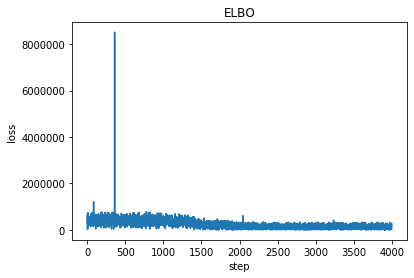

In [12]:
elbo_loss(losses_3DA, 4000)

### Hyperparameter change

In [13]:
def hyperparameters(a, b, x):
    plt.subplot(1,2,1)
    plt.plot(a)
    plt.plot(b)
    
    plt.subplot(1,2,2)
    plt.plot(x)

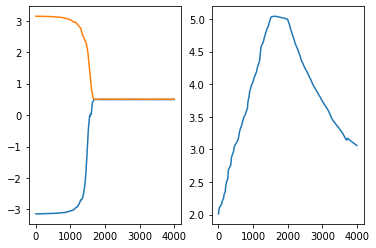

In [14]:
hyperparameters(a_psi_2, b_psi_2, x_psi_2)

### Setting parameters

In [15]:
# Setting mu parameters
phi_2_mu_start_model = phi_2_start
phi_2_mu_end_model = phi_2_end
phi_3_mu_start_model = phi_3_start
phi_3_mu_end_model = phi_3_end

psi_1_mu_start_model = psi_1_start
psi_1_mu_end_model = psi_1_end
psi_2_mu_start_model = psi_2_start
psi_2_mu_end_model = psi_2_end

# Setting kappa parameters
phi_2_inv_kappa_model = phi_2_scale
phi_3_inv_kappa_model = phi_3_scale

psi_1_inv_kappa_model = psi_1_scale
psi_2_inv_kappa_model = psi_2_scale


# Initialising distributions
mu_phi_2_dist_model = dist.Uniform(phi_2_mu_start_model, phi_2_mu_end_model)
mu_phi_3_dist_model = dist.Uniform(phi_3_mu_start_model, phi_3_mu_end_model)

mu_psi_1_dist_model = dist.Uniform(psi_1_mu_start_model, psi_1_mu_end_model)
mu_psi_2_dist_model = dist.Uniform(psi_2_mu_start_model, psi_2_mu_end_model)

inv_kappa_phi_2_dist_model = dist.HalfNormal(phi_2_inv_kappa_model)
inv_kappa_phi_3_dist_model = dist.HalfNormal(phi_3_inv_kappa_model)

inv_kappa_psi_1_dist_model = dist.HalfNormal(psi_1_inv_kappa_model)
inv_kappa_psi_2_dist_model = dist.HalfNormal(psi_2_inv_kappa_model)

### Sampling from Von Mises (model)

In [16]:
def Sampler_VM_model(n_samples, n_AA, mus, kappas, bias=0, used_angles=[True, True, True]):
    '''
    n_samples -> number of samples.
    n_AA -> length of the peptides in AA.
    mus -> mu distributions of DA angles as a list of lists.
    inv_kappas -> inv_kappa distributions of DA angles as a list of lists.
    used_angles -> a list of truth values specifying which DA to sample.
    returns -> a tensor of shape [n_AA, n_samples, 3]
    '''
    phi = used_angles[0]
    psi = used_angles[1]
    omega = used_angles[2]
    
    # Making samples    
    samples = []
    for AA in range(n_AA):
        angles = []
        for sample in range(n_samples):
            dihedral_angles = []
            if phi and AA != 0:
                phi_angle = pyro.distributions.VonMises(mus[AA][0].sample_n(1).item(),
                                                              (bias+kappas[AA][0].sample_n(1).item())).sample_n(1).item()
                dihedral_angles.append(float(phi_angle))
            else:
                dihedral_angles.append(float(0.))
                
            if psi and AA != n_AA-1:
                psi_angle = pyro.distributions.VonMises(mus[AA][1].sample_n(1).item(),
                                                              (bias+kappas[AA][1].sample_n(1).item())).sample_n(1).item()
                dihedral_angles.append(float(psi_angle))
            else:
                dihedral_angles.append(float(0.))
                
            if omega and AA != n_AA-1:
                omega_angle = np.pi
                dihedral_angles.append(float(omega_angle))
            else:
                dihedral_angles.append(float(0.))
            
            angles.append(np.array((dihedral_angles)))
                
        samples.append(angles)

    samples = torch.tensor(samples)
    return samples

In [17]:
mus_model = [[None, mu_psi_1_dist_model, None], [mu_phi_2_dist_model, mu_psi_2_dist_model, None], [mu_phi_3_dist_model, None, None]]
inv_kappas_model = [[None, inv_kappa_psi_1_dist_model, None], [inv_kappa_phi_2_dist_model, inv_kappa_psi_2_dist_model, None], [inv_kappa_phi_3_dist_model, None, None]]

_3DA_atoms_model = Sampler_VM_model(n_samples=1000, n_AA=3, mus=mus_model, kappas=inv_kappas_model, bias=100, used_angles=[True, True, True])

### Plotting overlay of Von Mises distribution

psi 1


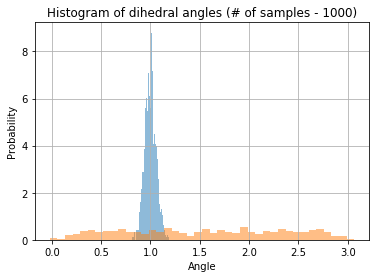

phi 2


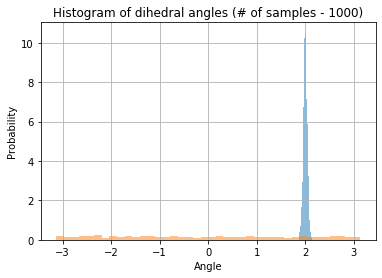

psi 2


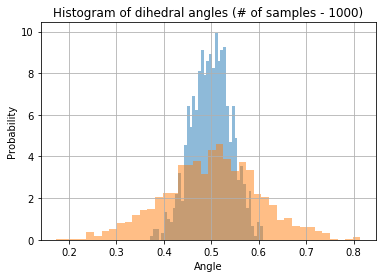

phi 3


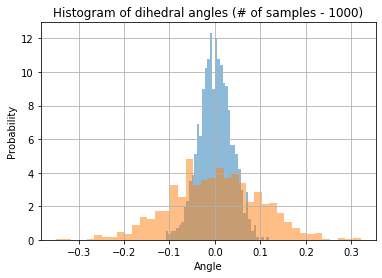

In [18]:
print('psi 1')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_model, AAs=[1], angles=[1])
print('phi 2')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_model, AAs=[2], angles=[0])
print('psi 2')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_model, AAs=[2], angles=[1])
print('phi 3')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_model, AAs=[3], angles=[0])

## Pyro model for 3D coordinates

### Turning angles into 3D coords

In [19]:
# Run pNERF algorithm on dihedral angles obtained using Von Mises distribution
points_3DA_atoms = dihedral_to_point((_3DA_atoms).float())
coordinates_3DA_atoms = point_to_coordinate(points_3DA_atoms, num_fragments=2)

print(_3DA_atoms.shape)
print(_3DA_atoms[:,0,:])
print(coordinates_3DA_atoms.shape)
print(coordinates_3DA_atoms[:,0,:])

torch.Size([3, 1000, 3])
tensor([[0.0000, 1.0143, 3.1416],
        [1.9842, 0.5234, 3.1416],
        [0.0541, 0.0000, 0.0000]], dtype=torch.float64)
torch.Size([9, 1000, 3])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.7661,  1.2405,  0.0000],
        [ 0.4175,  2.1035,  1.2058],
        [ 1.0610,  3.2618,  1.3039],
        [ 0.3655,  4.5374,  1.1819],
        [-1.0747,  4.4283,  1.6660],
        [-1.8018,  5.5383,  1.5984],
        [-1.2690,  6.7696,  1.0276],
        [ 0.1663,  6.5814,  0.5536]])


### pNeRF function for observations

In [20]:
def pnerf(dihedral_angles):
    points_dihedral_angles = dihedral_to_point((dihedral_angles).float())
    coordinates_dihedral_angles = point_to_coordinate(points_dihedral_angles, num_fragments=2)
    return coordinates_dihedral_angles

### Model and guide for 3D coords

In [21]:
pyro.set_rng_seed(101)

# clear the param store in case we're in REPL
pyro.clear_param_store()

def model_3D(data):
    # Sampling mu and kappa
    psi_1 = pyro.sample("psi_1", dist.VonMises(0, 0.1))
    phi_2 = pyro.sample("phi_2", dist.VonMises(0, 0.1))    
    psi_2 = pyro.sample("psi_2", dist.VonMises(0, 0.1))    
    phi_3 = pyro.sample("phi_3", dist.VonMises(0, 0.1))
    das = torch.tensor([[[0., psi_1, np.pi]],[[phi_2, psi_2, np.pi]],[[phi_3, 0., 0.]]])
    coords_3d = pnerf(das)
    
    _3a_x = coords_3d[2,:,0]
    _4a_x = coords_3d[3,:,0]
    _5a_x = coords_3d[4,:,0]
    _6a_x = coords_3d[5,:,0]
    _7a_x = coords_3d[6,:,0]
    _8a_x = coords_3d[7,:,0]
    _9a_x = coords_3d[8,:,0]
    
    _3a_y = coords_3d[2,:,1]
    _4a_y = coords_3d[3,:,1]
    _5a_y = coords_3d[4,:,1]
    _6a_y = coords_3d[5,:,1]
    _7a_y = coords_3d[6,:,1]
    _8a_y = coords_3d[7,:,1]
    _9a_y = coords_3d[8,:,1]
    
    _3a_z = coords_3d[2,:,2]
    _4a_z = coords_3d[3,:,2]
    _5a_z = coords_3d[4,:,2]
    _6a_z = coords_3d[5,:,2]
    _7a_z = coords_3d[6,:,2]
    _8a_z = coords_3d[7,:,2]
    _9a_z = coords_3d[8,:,2]
    
    # Looping over the observed data in an independant manner
    with pyro.plate('3D_coords'):
        pyro.sample("obs_3D_3a_x", dist.Normal(_3a_x, 0.001), obs=data[2,:,0])
        pyro.sample("obs_3D_4a_x", dist.Normal(_4a_x, 0.001), obs=data[3,:,0])
        pyro.sample("obs_3D_5a_x", dist.Normal(_5a_x, 0.001), obs=data[4,:,0])
        pyro.sample("obs_3D_6a_x", dist.Normal(_6a_x, 0.001), obs=data[5,:,0])
        pyro.sample("obs_3D_7a_x", dist.Normal(_7a_x, 0.001), obs=data[6,:,0])
        pyro.sample("obs_3D_8a_x", dist.Normal(_8a_x, 0.001), obs=data[7,:,0])
        pyro.sample("obs_3D_9a_x", dist.Normal(_9a_x, 0.001), obs=data[8,:,0])
        
        pyro.sample("obs_3D_3a_y", dist.Normal(_3a_y, 0.001), obs=data[2,:,1])
        pyro.sample("obs_3D_4a_y", dist.Normal(_4a_y, 0.001), obs=data[3,:,1])
        pyro.sample("obs_3D_5a_y", dist.Normal(_5a_y, 0.001), obs=data[4,:,1])
        pyro.sample("obs_3D_6a_y", dist.Normal(_6a_y, 0.001), obs=data[5,:,1])
        pyro.sample("obs_3D_7a_y", dist.Normal(_7a_y, 0.001), obs=data[6,:,1])
        pyro.sample("obs_3D_8a_y", dist.Normal(_8a_y, 0.001), obs=data[7,:,1])
        pyro.sample("obs_3D_9a_y", dist.Normal(_9a_y, 0.001), obs=data[8,:,1])
        
        pyro.sample("obs_3D_3a_z", dist.Normal(_3a_z, 0.001), obs=data[2,:,2])
        pyro.sample("obs_3D_4a_z", dist.Normal(_4a_z, 0.001), obs=data[3,:,2])
        pyro.sample("obs_3D_5a_z", dist.Normal(_5a_z, 0.001), obs=data[4,:,2])
        pyro.sample("obs_3D_6a_z", dist.Normal(_6a_z, 0.001), obs=data[5,:,2])
        pyro.sample("obs_3D_7a_z", dist.Normal(_7a_z, 0.001), obs=data[6,:,2])
        pyro.sample("obs_3D_8a_z", dist.Normal(_8a_z, 0.001), obs=data[7,:,2])
        pyro.sample("obs_3D_9a_z", dist.Normal(_9a_z, 0.001), obs=data[8,:,2])
        
    
def guide_3D(data):    
    # Hyperparameters    
    mu_psi_1    = pyro.param('mu_psi_1', torch.tensor(0.)) 
    kappa_psi_1 = pyro.param('kappa_psi_1', torch.tensor(0.01), constraint=constraints.positive)
    
    mu_phi_2    = pyro.param('mu_phi_2', torch.tensor(0.)) 
    kappa_phi_2 = pyro.param('kappa_phi_2', torch.tensor(0.01), constraint=constraints.positive)
    
    mu_psi_2    = pyro.param('mu_psi_2', torch.tensor(0.)) 
    kappa_psi_2 = pyro.param('kappa_psi_2', torch.tensor(0.01), constraint=constraints.positive)
    
    mu_phi_3    = pyro.param('mu_phi_3', torch.tensor(0.)) 
    kappa_phi_3 = pyro.param('kappa_phi_3', torch.tensor(0.01), constraint=constraints.positive)
       
    # Sampling mu and kappa
    psi_1 = pyro.sample("psi_1", dist.VonMises(mu_psi_1, 10 + kappa_psi_1))
    phi_2 = pyro.sample("phi_2", dist.VonMises(mu_phi_2, 10 + kappa_phi_2))    
    psi_2 = pyro.sample("psi_2", dist.VonMises(mu_psi_2, 10 + kappa_psi_2))    
    phi_3 = pyro.sample("phi_3", dist.VonMises(mu_phi_3, 10 + kappa_phi_3))
    


### Optimization using Adam

In [22]:
pyro.set_rng_seed(101)

# number of steps
n_steps = 2000

# setup the optimizer
adam_params_3D = {"lr": 0.04, "betas": (0.90, 0.999)}
optimizer_3D = Adam(adam_params_3D)

adam_params_3D_2 = {"lr": 0.004, "betas": (0.90, 0.999)}
optimizer_3D_2 = Adam(adam_params_3D_2)

# setup the inference algorithm
svi_3D = SVI(model_3D, guide_3D, optimizer_3D, loss=Trace_ELBO())
svi_3D_2 = SVI(model_3D, guide_3D, optimizer_3D_2, loss=Trace_ELBO())

losses_3D, mu_psi_1_3D, kappa_psi_1_3D = [], [], []
# do gradient steps
for step in range(n_steps):
    losses_3D.append(svi_3D.step(coordinates_3DA_atoms))
    mu_psi_1_3D.append(pyro.param('mu_psi_1').item())
    kappa_psi_1_3D.append(pyro.param('kappa_psi_1').item())
    if step % 200 == 0:
        temp_m_psi_1 = round(pyro.param("mu_psi_1").item(), 3)
        temp_k_psi_1 = round(pyro.param("kappa_psi_1").item(), 3)
        temp_m_phi_2 = round(pyro.param("mu_phi_2").item(), 3)
        temp_k_phi_2 = round(pyro.param("kappa_phi_2").item(), 3)
        temp_m_psi_2 = round(pyro.param("mu_psi_2").item(), 3)
        temp_k_psi_2 = round(pyro.param("kappa_psi_2").item(), 3)
        temp_m_phi_3 = round(pyro.param("mu_phi_3").item(), 3)
        temp_k_phi_3 = round(pyro.param("kappa_phi_3").item(), 3)
        
        print('{}:'.format(step), end='')
        print("m_psi_1: ", temp_m_psi_1, end='')
        print("\tk_psi_1: ", temp_k_psi_1, end='')
        print("\tm_phi_2: ", temp_m_phi_2, end='')
        print("\tk_phi_2: ", temp_k_phi_2, end='')
        print("\tm_psi_2: ", temp_m_psi_2, end='')
        print("\tk_psi_2: ", temp_k_psi_2, end='')
        print("\tm_phi_3: ", temp_m_phi_3, end='')
        print("\tk_phi_3: ", temp_k_phi_3)
        
for step in range(n_steps):
    losses_3D.append(svi_3D_2.step(coordinates_3DA_atoms))
    mu_psi_1_3D.append(pyro.param('mu_psi_1').item())
    kappa_psi_1_3D.append(pyro.param('kappa_psi_1').item())
    if step % 200 == 0:
        temp_m_psi_1 = round(pyro.param("mu_psi_1").item(), 3)
        temp_k_psi_1 = round(pyro.param("kappa_psi_1").item(), 3)
        temp_m_phi_2 = round(pyro.param("mu_phi_2").item(), 3)
        temp_k_phi_2 = round(pyro.param("kappa_phi_2").item(), 3)
        temp_m_psi_2 = round(pyro.param("mu_psi_2").item(), 3)
        temp_k_psi_2 = round(pyro.param("kappa_psi_2").item(), 3)
        temp_m_phi_3 = round(pyro.param("mu_phi_3").item(), 3)
        temp_k_phi_3 = round(pyro.param("kappa_phi_3").item(), 3)
        
        print('{}:'.format(step), end='')
        print("m_psi_1: ", temp_m_psi_1, end='')
        print("\tk_psi_1: ", temp_k_psi_1, end='')
        print("\tm_phi_2: ", temp_m_phi_2, end='')
        print("\tk_phi_2: ", temp_k_phi_2, end='')
        print("\tm_psi_2: ", temp_m_psi_2, end='')
        print("\tk_psi_2: ", temp_k_psi_2, end='')
        print("\tm_phi_3: ", temp_m_phi_3, end='')
        print("\tk_phi_3: ", temp_k_phi_3)

# grab the learned variational parameters
psi_1_mu = pyro.param("mu_psi_1").item()
psi_1_kappa = pyro.param("kappa_psi_1").item()

phi_2_mu = pyro.param("mu_phi_2").item()
phi_2_kappa = pyro.param("kappa_phi_2").item()

psi_2_mu = pyro.param("mu_psi_2").item()
psi_2_kappa = pyro.param("kappa_psi_2").item()

phi_3_mu = pyro.param("mu_phi_3").item()
phi_3_kappa = pyro.param("kappa_phi_3").item()

print("\nFinal parameters\npsi_1_mu: {}\npsi_1_kappa: {}".format(psi_1_mu, psi_1_kappa))
print("\nFinal parameters\nphi_2_mu: {}\nphi_2_kappa: {}".format(phi_2_mu, phi_2_kappa))
print("\nFinal parameters\npsi_2_mu: {}\npsi_2_kappa: {}".format(psi_2_mu, psi_2_kappa))
print("\nFinal parameters\nphi_3_mu: {}\nphi_3_kappa: {}".format(phi_3_mu, phi_3_kappa))

0:m_psi_1:  0.04	k_psi_1:  0.01	m_phi_2:  0.04	k_phi_2:  0.01	m_psi_2:  -0.04	k_psi_2:  0.01	m_phi_3:  0.04	k_phi_3:  0.01
200:m_psi_1:  0.614	k_psi_1:  0.007	m_phi_2:  0.783	k_phi_2:  0.006	m_psi_2:  0.464	k_psi_2:  0.011	m_phi_3:  0.632	k_phi_3:  0.003
400:m_psi_1:  1.452	k_psi_1:  0.01	m_phi_2:  1.416	k_phi_2:  0.006	m_psi_2:  0.774	k_psi_2:  0.015	m_phi_3:  0.174	k_phi_3:  0.003
600:m_psi_1:  1.261	k_psi_1:  0.023	m_phi_2:  1.563	k_phi_2:  0.008	m_psi_2:  0.751	k_psi_2:  0.014	m_phi_3:  -0.043	k_phi_3:  0.004
800:m_psi_1:  0.942	k_psi_1:  0.242	m_phi_2:  1.88	k_phi_2:  0.042	m_psi_2:  0.716	k_psi_2:  0.015	m_phi_3:  0.201	k_phi_3:  0.005
1000:m_psi_1:  0.916	k_psi_1:  33.414	m_phi_2:  1.933	k_phi_2:  8.269	m_psi_2:  0.918	k_psi_2:  0.025	m_phi_3:  -0.131	k_phi_3:  0.007
1200:m_psi_1:  1.083	k_psi_1:  200.25	m_phi_2:  1.892	k_phi_2:  118.796	m_psi_2:  0.908	k_psi_2:  0.033	m_phi_3:  -0.154	k_phi_3:  0.012
1400:m_psi_1:  0.922	k_psi_1:  574.066	m_phi_2:  1.918	k_phi_2:  140.371	m_psi

### ELBO loss

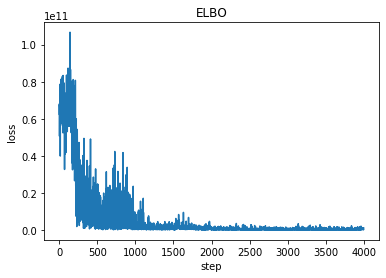

In [23]:
elbo_loss(losses_3D, 2000)

### Hyperparameter change

In [24]:
def hyperparameters_3D(a, b):
    plt.subplot(1,2,1)
    plt.plot(a)
    
    plt.subplot(1,2,2)
    plt.plot(b)

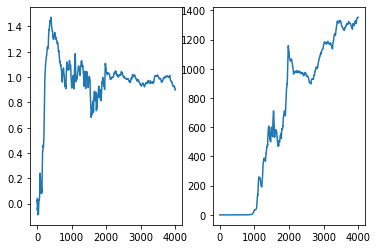

In [25]:
hyperparameters_3D(mu_psi_1_3D, kappa_psi_1_3D)

### Sampling from Von Mises (3D model)

In [26]:
def Sampler_VM_3Dmodel(n_samples, n_AA, mus, kappas, bias=0, used_angles=[True, True, True]):
    phi = used_angles[0]
    psi = used_angles[1]
    omega = used_angles[2]
    
    # Making samples    
    samples = []
    for AA in range(n_AA):
        angles = []
        for sample in range(n_samples):
            dihedral_angles = []
            if phi and AA != 0:
                phi_angle = pyro.distributions.VonMises(mus[AA][0],
                                                              (bias+kappas[AA][0])).sample_n(1).item()
                dihedral_angles.append(float(phi_angle))
            else:
                dihedral_angles.append(float(0.))
                
            if psi and AA != n_AA-1:
                psi_angle = pyro.distributions.VonMises(mus[AA][1],
                                                              (bias+kappas[AA][1])).sample_n(1).item()
                dihedral_angles.append(float(psi_angle))
            else:
                dihedral_angles.append(float(0.))
                
            if omega and AA != n_AA-1:
                omega_angle = np.pi
                dihedral_angles.append(float(omega_angle))
            else:
                dihedral_angles.append(float(0.))
            
            angles.append(np.array((dihedral_angles)))
                
        samples.append(angles)

    samples = torch.tensor(samples)
    return samples

In [27]:
mu_psi_1_model_3D = psi_1_mu
kappa_psi_1_model_3D = psi_1_kappa

mu_phi_2_model_3D = phi_2_mu
kappa_phi_2_model_3D = phi_2_kappa

mu_psi_2_model_3D = psi_2_mu
kappa_psi_2_model_3D = psi_2_kappa

mu_phi_3_model_3D = phi_3_mu
kappa_phi_3_model_3D = phi_3_kappa

In [28]:
mus_model_3D = [[None, mu_psi_1_model_3D, None], [mu_phi_2_model_3D, mu_psi_2_model_3D, None], [mu_phi_3_model_3D, None, None]]
kappas_model_3D = [[None, kappa_psi_1_model_3D, None], [kappa_phi_2_model_3D, kappa_psi_2_model_3D, None], [kappa_phi_3_model_3D, None, None]]

_3DA_atoms_3Dmodel = Sampler_VM_3Dmodel(n_samples=1000, n_AA=3, mus=mus_model_3D, kappas=kappas_model_3D, bias=10, used_angles=[True, True, True])

### Plotting overlay of Von Mises distribution (3D)

psi 1


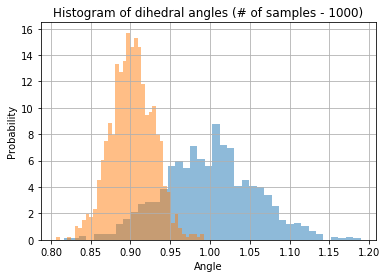

phi 2


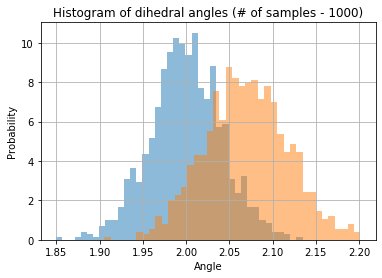

psi 2


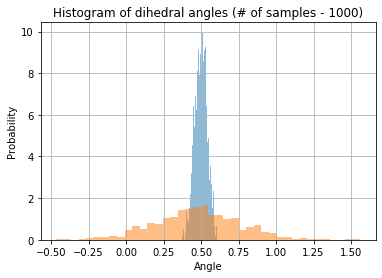

phi 3


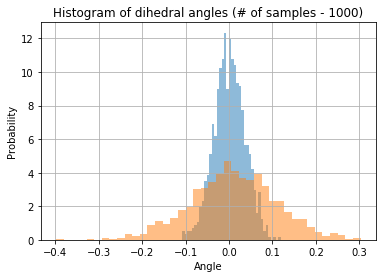

In [29]:
print('psi 1')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_3Dmodel, AAs=[1], angles=[1])
print('phi 2')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_3Dmodel, AAs=[2], angles=[0])
print('psi 2')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_3Dmodel, AAs=[2], angles=[1])
print('phi 3')
plotting_VM(data_1=_3DA_atoms, data_2=_3DA_atoms_3Dmodel, AAs=[3], angles=[0])

### Visualisation of sampled data and two models

In [30]:
def plotting_VM_all(data_1, AAs, angles, data_2=torch.tensor([[[0.]]]), data_3=torch.tensor([[[0.]]])):
    n_samples = len(data_1[0])
    
    if angles[0] == 0:
        da = 'phi'
    elif angles[0] == 1:
        da = 'psi'
    else:
        da = 'omega'
        
    # the histogram of the data
    plt.figure()
    if data_2.shape[1] == 1:
        for AA in range(len(AAs)):
            color = plt.rcParams['axes.prop_cycle'].by_key()['color']
            if angles[AA] == 0:
                da = 'phi'
            elif angles[AA] == 1:
                da = 'psi'
            else:
                da = 'omega'
            n, bins, patches = plt.hist([sample[angles[AA]] for sample in data_1[AAs[AA]-1][:]], 40, density=1, alpha=0.5)
    else:
        for AA in range(len(AAs)):
            color = plt.rcParams['axes.prop_cycle'].by_key()['color']
            if angles[AA] == 0:
                da = 'phi'
            elif angles[AA] == 1:
                da = 'psi'
            else:
                da = 'omega'
            n, bins, patches = plt.hist([sample[angles[AA]] for sample in data_1[AAs[AA]-1][:]], 40, label='fake data', density=1, alpha=0.5)
            n, bins, patches = plt.hist([sample[angles[AA]] for sample in data_2[AAs[AA]-1][:]], 40, label='DA model', density=1, alpha=0.5)
            n, bins, patches = plt.hist([sample[angles[AA]] for sample in data_3[AAs[AA]-1][:]], 40, label='3D model', density=1, alpha=0.5)
            plt.xlabel('Angle')
    plt.ylabel('Probability')
    plt.title('Histogram of {}_{} angles (# of samples - {})'.format(da, AAs[0], n_samples)) 
    plt.grid(True)
    plt.legend()
    #plt.savefig('Output\\Histogram of {}_{} angles (# of samples - {})'.format(da, AAs[0], n_samples))
    plt.show()

psi 1


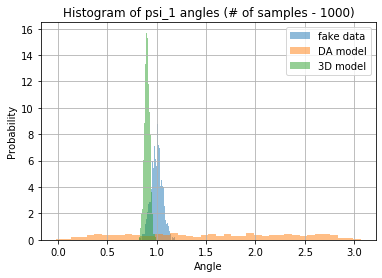

phi 2


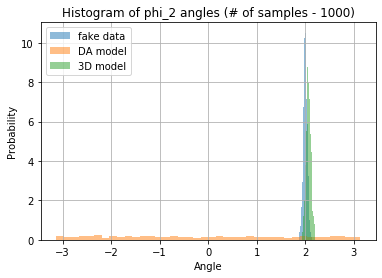

psi 2


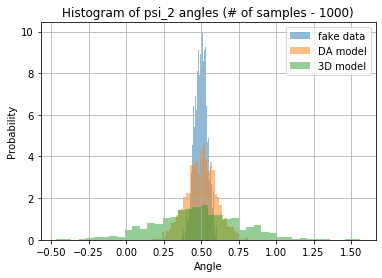

phi 3


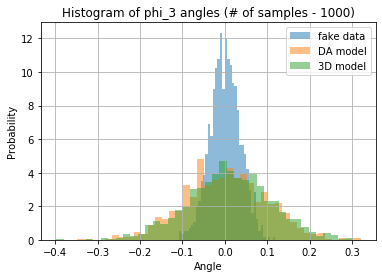

In [31]:
print('psi 1')
plotting_VM_all(data_1=_3DA_atoms, data_2=_3DA_atoms_model, data_3=_3DA_atoms_3Dmodel, AAs=[1], angles=[1])
print('phi 2')
plotting_VM_all(data_1=_3DA_atoms, data_2=_3DA_atoms_model, data_3=_3DA_atoms_3Dmodel, AAs=[2], angles=[0])
print('psi 2')
plotting_VM_all(data_1=_3DA_atoms, data_2=_3DA_atoms_model, data_3=_3DA_atoms_3Dmodel, AAs=[2], angles=[1])
print('phi 3')
plotting_VM_all(data_1=_3DA_atoms, data_2=_3DA_atoms_model, data_3=_3DA_atoms_3Dmodel, AAs=[3], angles=[0])